# Instabilities in single RF systems

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mbtrack2 import CavityResonator
from albums import scan_MC_psi_I0

mbtrack2 version 0.8.0.18
--------------------------------------------------
If used in a publication, please cite mbtrack2 paper and the zenodo archive for the corresponding code version (and other papers for more specific features).
[1] A. Gamelin, W. Foosang, N. Yamamoto, V. Gubaidulin and R. Nagaoka, “mbtrack2”. Zenodo, Dec. 16, 2024. doi: 10.5281/zenodo.14418989.
[2] A. Gamelin, W. Foosang, and R. Nagaoka, “mbtrack2, a Collective Effect Library in Python”, presented at the 12th Int. Particle Accelerator Conf. (IPAC'21), Campinas, Brazil, May 2021, paper MOPAB070.




## Ring and cavity setup

In [2]:
from mbtrack2.tracking import Synchrotron, Electron
from mbtrack2.utilities import Optics

def SOLEIL_II(V_RF=1.7e6):
    """
    SOLEIL II lattice v2366 w/ RF parameters from November 2023 RF budget.

    Parameters
    ----------
    V_RF : float, optional
        Total RF voltage in [V]. 
        The default is 1.7e6.
        
    Returns
    -------
    ring : Synchrotron object
        TDR lattice v2366_v3.

    """
    L = 353.97
    E0 = 2.75e9
    particle = Electron()
    ac = 1.05751e-04
    tune = np.array([54.2, 18.3])
    chro = np.array([1.6, 1.6])
    beta = np.array([3.288, 4.003])
    alpha = np.array([0, 0])
    dispersion = np.array([0, 0, 0, 0])
    h = 416
    particle = Electron()
    mcf_order = np.array([-0.00192226,  0.00061511,  0.00010695])
    U0 = 469e3
    tau = np.array([7.64e-3, 13.83e-3, 11.64e-3])
    sigma_delta = 9.063e-4
    emit = np.array([83.7e-12, 83.7e-12*0.01])
        
    optics = Optics(local_beta=beta, local_alpha=alpha, 
                  local_dispersion=dispersion)
    ring = Synchrotron(h, optics, particle, L=L, E0=E0, ac=ac, U0=U0, tau=tau,
                   emit=emit, tune=tune, sigma_delta=sigma_delta, chro=chro, 
                   mcf_order=mcf_order)
    
    tuneS = ring.synchrotron_tune(V_RF)
    ring.sigma_0 = (ring.sigma_delta * np.abs(ring.eta()) 
                    / (tuneS * 2 * np.pi * ring. f0))
    ring.get_longitudinal_twiss(V_RF)
        
    return ring

In [3]:
ring = SOLEIL_II(V_RF=1.7e6)

I0 = 1.1
MC = CavityResonator(ring, m=1, Rs=5e6, Q=35.7e3, QL=6e3, detune=1e6, Ncav=4)
MC.Vc = 1.7e6
MC.theta = np.arccos(ring.U0/MC.Vc)
MC.set_optimal_detune(I0)
MC.set_generator(I0)

# HC is there just to be able to use scan functions but with RS=1ohm does nothing
HC = CavityResonator(ring, m=4, Rs=1, Q=31e3, QL=31e3, detune=1e6, Ncav=2)
HC.Vg = 0
HC.theta_g = 0

# Main cavity tuning vs beam current scan

In the case of a single RF system, the positive tuning side is Robinson unstable (AC Robinson) while for high beam current the negative tuning side is succeptible to zero-frequency instability (DC Robinson or equilibirum phase instability).

## Case with synchrotron longitudinal damping

rank=0:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 46/50 [00:06<00:00,  6.55it/s]/home/gamelina/work/Python_dev/robinsonmodes/albums/robinson.py:639: RuntimeWarning: invalid value encountered in sqrt
  y0 = x[0] - np.sqrt(self._Omega_B13(x[0], x[1], bunch_length, omega_r, "-", abs_val))
/home/gamelina/anaconda3/envs/pycolleff/lib/python3.11/site-packages/scipy/optimize/_nonlin.py:931: RuntimeWarning: invalid value encountered in divide
  d = v / vdot(df, v)
rank=0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:06<00:00,  7.60it/s]
/home/gamelina/work/Python_dev/robinsonmodes/albums/plot_func.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  i

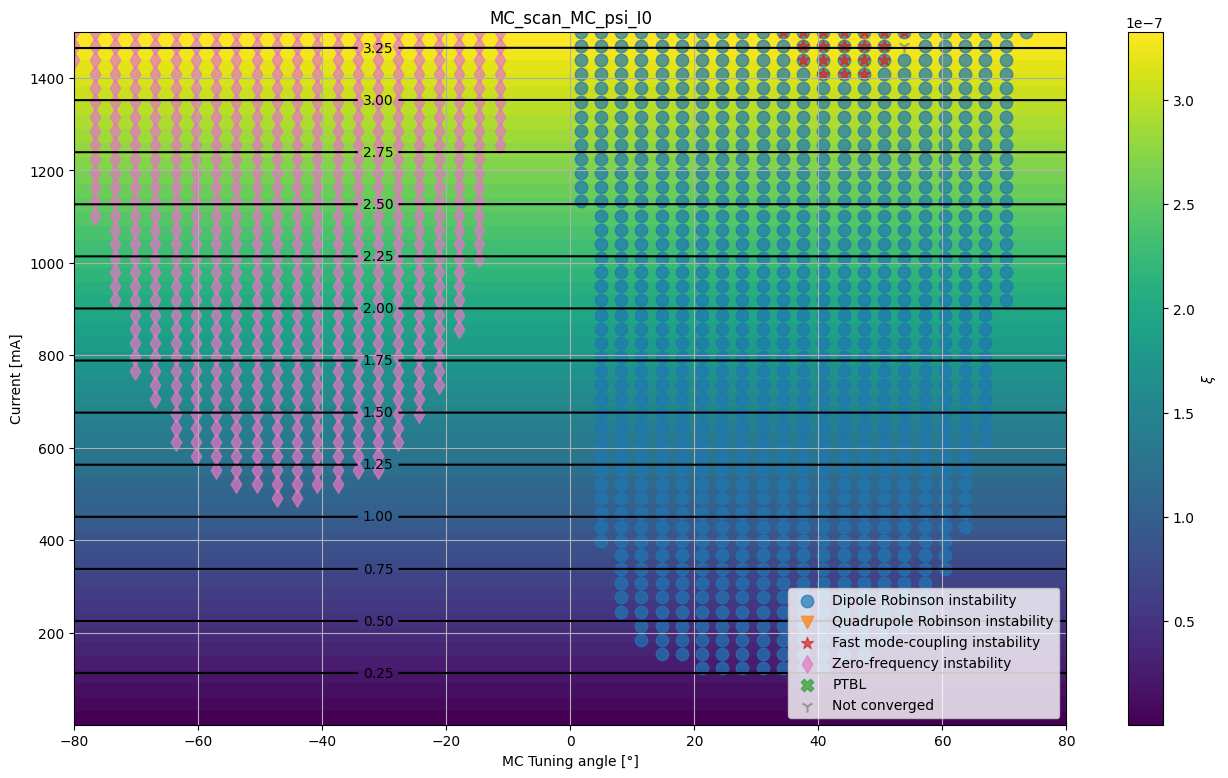

In [4]:
psi_MC_vals = np.linspace(-80, 80, 50)
I0_vals = np.linspace(1e-3, 1.5, 50)

scan_MC_psi_I0("MC_scan",
                MC,
                HC,
                ring,
                psi_MC_vals,
                I0_vals,
                method="Alves",
                save=False,
                plot_list=["xi"],
                auto_set_MC_theta=False, # needed so MC is not setup with regards to HC parameters
                optimal_tunning=False) # needed so MC is not set at optimal tuning

## Case without synchrotron longitudinal damping

Without synchrotron damping, the "textbook" picture is obtained.

See Fig.7 of [1] for example.

[1]: Pedersen, F. (1994). Multibunch instabilities. In Frontiers of Particle Beams: Factories with e+ e− Rings (pp. 269-292). Springer, Berlin, Heidelberg.

rank=0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 82.85it/s]


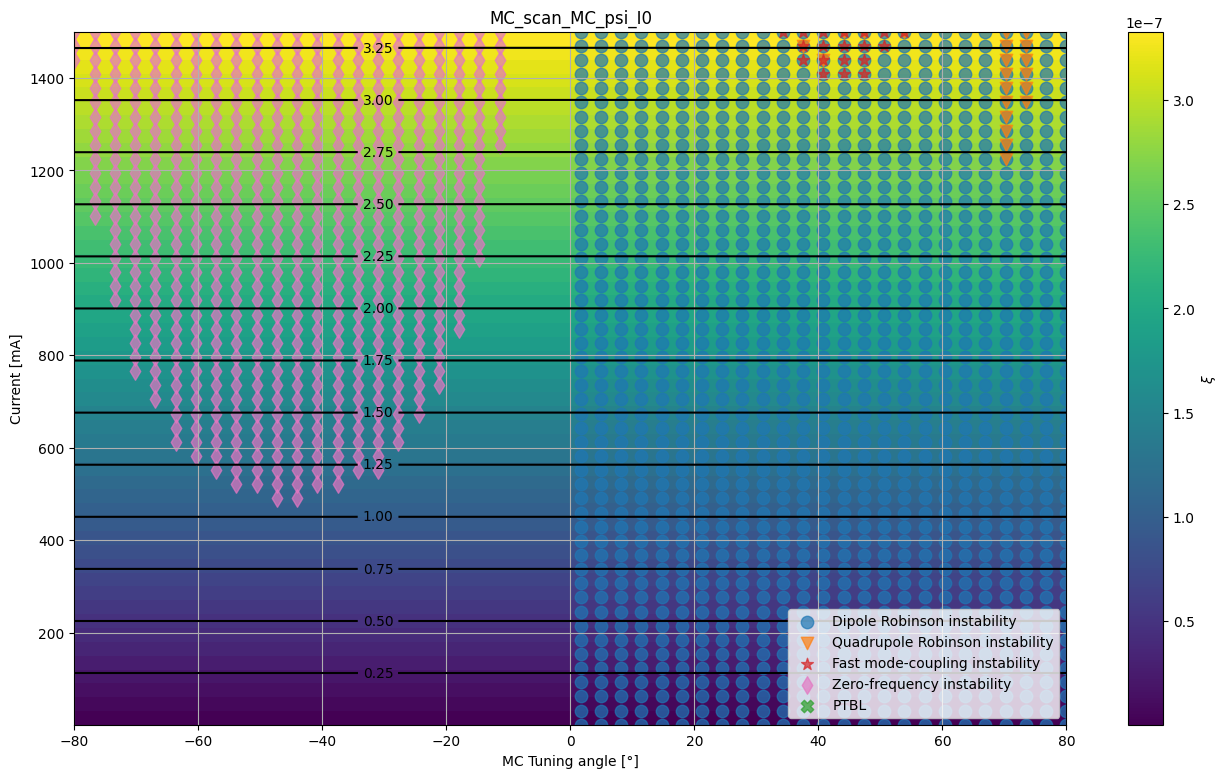

In [5]:
ring.tau[2] = 100 # Long damping time

psi_MC_vals = np.linspace(-80, 80, 50)
I0_vals = np.linspace(1e-3, 1.5, 50)

scan_MC_psi_I0("MC_scan",
                MC,
                HC,
                ring,
                psi_MC_vals,
                I0_vals,
                method="Alves",
                save=False,
                use_PTBL_He=True, # avoid 'False positive' PTBL because of no synchrotron longitudinal damping
                plot_list=["xi"],
                auto_set_MC_theta=False, # needed so MC is not setup with regards to HC parameters
                optimal_tunning=False) # needed so MC is not set at optimal tuning